<a href="https://colab.research.google.com/github/yashsantani/autoencoder-SAR-image-denoising-/blob/master/image_denoising_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#import libraries
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
#importing to read images
import cv2
import glob
#creating a list to store images
images=[]
#iterating and reading every image as well as storing it
for img in glob.glob("/content/drive/MyDrive/sar image cleaning/s2/*.png"):
  cv_img=cv2.imread(img,0)
  images.append(cv_img)

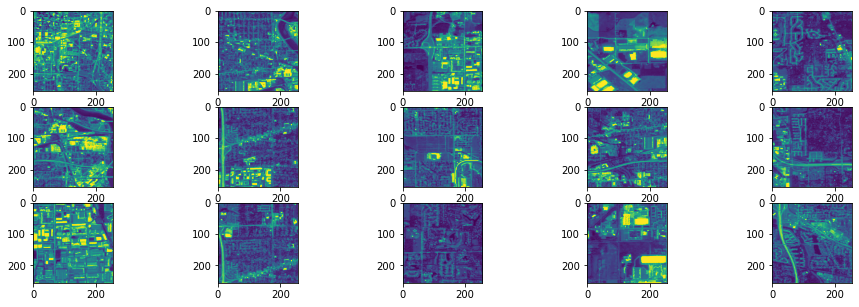

In [ ]:
#plt.rcParams['figure.figsize']=(256,2)
#plt.imshow(images[1])

#showing images in rows and columns
fig,axes=plt.subplots(3,5,figsize=(16,5))
count=0
for i in range(3):
  for j in range(5):
    axes[i,j].imshow(images[count])
    count+=1


In [ ]:
#Changing into numpy array to convert into normalize images
npimages=np.array(images)


In [ ]:
#train test split 
from sklearn.model_selection import train_test_split
X_train, X_test=train_test_split(npimages,test_size=0.2,random_state=42)

In [ ]:
#normalising images
X_train=X_train/255.0
X_test=X_test/255.0

In [ ]:
#adding noise to images
noise_factor=0.1
X_train_noise=X_train+noise_factor*np.random.normal(loc=0,scale=1,size=X_train.shape)
X_test_noise=X_test+noise_factor*np.random.normal(loc=0,scale=1,size=X_test.shape)

In [ ]:
X_train.shape

(3200, 256, 256)

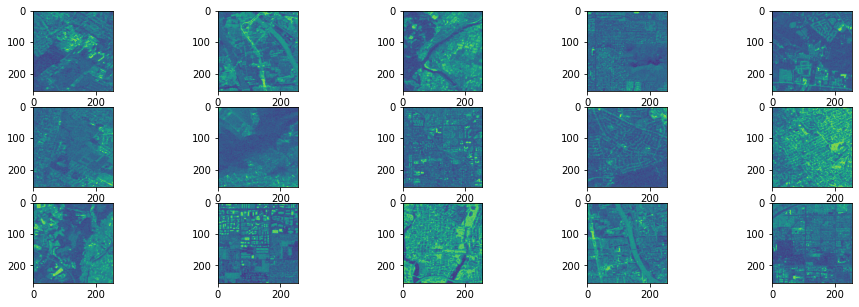

In [ ]:
fig,axes=plt.subplots(3,5,figsize=(16,5))
count=0
for i in range(3):
  for j in range(5):
    axes[i,j].imshow(X_train_noise[count])
    count+=1

In [ ]:
#reshape to feed in cnn 
#converting it in 3d tensor
X_train=X_train.reshape(X_train.shape[0],256,256,1)
X_test=X_test.reshape(X_test.shape[0],256,256,1)

X_train_noise=X_train_noise.reshape(X_train_noise.shape[0],256,256,1)
X_test_noise=X_test_noise.reshape(X_test_noise.shape[0],256,256,1)

X_train.shape,X_train_noise.shape

((3200, 256, 256, 1), (3200, 256, 256, 1))

In [ ]:
#Model
from keras.models import Model
from keras.layers import Input,Conv2D,MaxPool2D,Dense,UpSampling2D,BatchNormalization
from keras.callbacks import ModelCheckpoint

import tensorflow as tf

# Encoder
2 layers for convolution and 3 pooling layers 

encoded here is a latent vector/bottleneck layer

converting 256 x 256 matrix into 64 x 64



In [ ]:

#encoder
encoder_input=Input(shape=X_train.shape[1:])
x=Conv2D(32,(3,3),activation='relu',padding='same')(encoder_input)
x=BatchNormalization()(x)
x=MaxPool2D(pool_size=(2,2),padding='same')(x)
x=Conv2D(32,(3,3),activation='relu',padding='same')(x)
x=BatchNormalization()(x)
encoded=MaxPool2D(pool_size=(2,2),padding='same')(x)

#Decoder 

3 convolution layers and 2 layers to upsample

upsampling from 64 x 64 to 256 x 256

In [ ]:
#decoder
x=Conv2D(32,(3,3),activation='relu',padding='same')(encoded)
x=BatchNormalization()(x)
x=UpSampling2D()(x)
x=Conv2D(32,(3,3),activation='relu',padding='same')(x)
x=BatchNormalization()(x)
x=UpSampling2D()(x)
decoded=Conv2D(1,(3,3),activation='sigmoid',padding='same')(x)

In [ ]:
autoencoder=Model(encoder_input,decoded,name='Denoising_Model')
autoencoder.summary()

Model: "Denoising_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 32)      320       
                                                                 
 batch_normalization (BatchN  (None, 256, 256, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      9248      
                                                                 
 batch_normalization_1 (Batc  (None, 128, 128, 32) 

In [ ]:
autoencoder.compile(loss='binary_crossentropy',optimizer='adam')

In [ ]:
#training
checkpoint=ModelCheckpoint("denoisingmodel.h5",save_best_only=True,save_weights_only=False,verbose=1)
history=autoencoder.fit(X_train_noise,X_train,batch_size=128,epochs=30,callbacks=checkpoint,validation_split=0.25,verbose=2)


Epoch 1/30

Epoch 1: val_loss improved from inf to 0.66360, saving model to denoisingmodel.h5
19/19 - 19s - loss: 0.6573 - val_loss: 0.6636 - 19s/epoch - 978ms/step
Epoch 2/30

Epoch 2: val_loss improved from 0.66360 to 0.63319, saving model to denoisingmodel.h5
19/19 - 9s - loss: 0.5941 - val_loss: 0.6332 - 9s/epoch - 460ms/step
Epoch 3/30

Epoch 3: val_loss improved from 0.63319 to 0.62091, saving model to denoisingmodel.h5
19/19 - 9s - loss: 0.5709 - val_loss: 0.6209 - 9s/epoch - 461ms/step
Epoch 4/30

Epoch 4: val_loss improved from 0.62091 to 0.61821, saving model to denoisingmodel.h5
19/19 - 9s - loss: 0.5513 - val_loss: 0.6182 - 9s/epoch - 462ms/step
Epoch 5/30

Epoch 5: val_loss did not improve from 0.61821
19/19 - 9s - loss: 0.5428 - val_loss: 0.6205 - 9s/epoch - 461ms/step
Epoch 6/30

Epoch 6: val_loss did not improve from 0.61821
19/19 - 9s - loss: 0.5410 - val_loss: 0.6222 - 9s/epoch - 462ms/step
Epoch 7/30

Epoch 7: val_loss improved from 0.61821 to 0.61547, saving model t

In [ ]:
def vis_data(data,row,column):
  data=data.reshape(data.shape[0],256,256)
  count=0
  fig,axes=plt.subplots(row,column,figsize=(16,5))
  for i in range (row):
    for j in range(column):
      axes[i,j].imshow(data[count])
      count+=1


#noisy data before

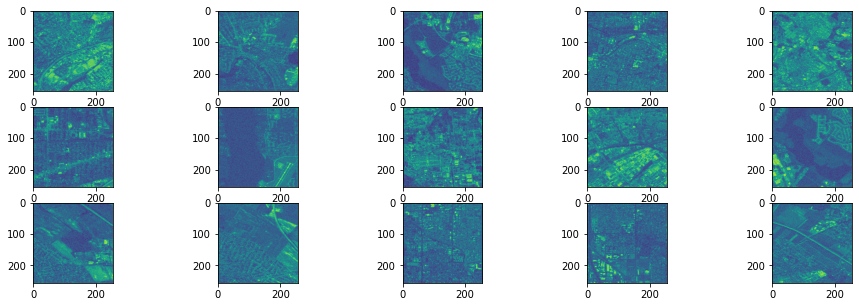

In [ ]:
vis_data(X_test_noise[:15],3,5)

In [ ]:
pred=autoencoder.predict(X_test_noise[:20])
pred.shape

(20, 256, 256, 1)

#noisy data after

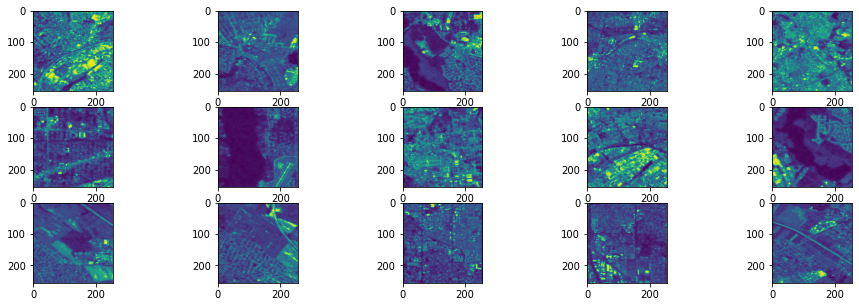

In [ ]:
vis_data(pred,3,5)